## Visualisation
### How to make a basic light-curve from the MWATS dataframes. 

In [58]:
import numpy as np
import plots as pl
import pandas as pd
import matplotlib.pyplot as plt 
import os
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [59]:
# Generic function for plotting light-curves and stats.
def plot_lc(source):
    all = filtered_raw_data[filtered_raw_data.source_id == source]
    all = all.sort_values(by='jd')
    plt.figure(figsize=(7, 8))
    plt.subplot(2,1,1)
    f = list(all.raw_peak_flux)
    s_stats = stats[stats.source_id == source]
    plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
    #plt.title(str(source)+' RA='+str(s_stats.ra)+' DEC='+str(s_stats.dec))
    plt.plot(list(f), 'k.', label='Flux')
    plt.xlabel('Observation Number')
    plt.ylabel('Flux (Jy)')
    # Non-averaged
    plt.subplot(2,1,2)
    plt.plot(all.jd, all.raw_peak_flux, 'k.', label='Flux')
    ts = []
    ys = []
    for t in all.jd:
        sli = stats[stats.source_id == source]
        y = (sli.grad * t) + sli.y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'k-.', label='$\\nabla_{S} = $'+str( round(float(sli.sig),2) ))
        
    # Averaged 
    avg = filtered_raw_avg_data[filtered_raw_avg_data.source_id == source]
    plt.errorbar(avg.mean_jd, avg.median_flux, avg.std_flux, fmt='ro', label="Median flux", markersize=10)
    ts = []
    ys = []
    for t in avg.mean_jd:
        sli = stats[stats.source_id == source]
        y = (sli.avg_grad * t) + sli.avg_y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'r-.', label='Median $\\nabla_{S} = $'+str( round(float(sli.avg_sig),2) ))
    #plt.ylim(np.mean(f)*0.8, np.mean(f)*1.2)
    plt.xlabel('Time (JD)')
    plt.ylabel('Flux (Jy)')
    #plt.savefig('thumbs/'+str(source)+'_Avg_LC.jpg')
    plt.legend()
    plt.close

In [60]:
# Function for plotting 
def plot_n_lc(source):
    plt.figure(figsize=[8,6])
    gs = gridspec.GridSpec(3, 2)
    n = neighbours[neighbours.source_id == source]
    for num in range(5):
        if num == 0:
               neigh = n.n_id1.values[0]
               colour = 'm'
        if num == 1:
               neigh = n.n_id2.values[0]
               colour = 'y'
        if num == 2:
               neigh = n.n_id3.values[0]
               colour = 'c'
        if num == 3:
               neigh = n.n_id4.values[0]
               colour = 'b'
        if num == 4:
               neigh = n.n_id5.values[0]
               colour = 'r'
        plt.subplot(gs[num])    
        s_stats = stats[stats.source_id == source]
        main = filtered_raw_data[filtered_raw_data.source_id == source]
        main = main.sort_values(by='jd')
        n = neighbours[neighbours.source_id == source]
        n_data = filtered_raw_data[filtered_raw_data.source_id == neigh]
        n_data = n_data.sort_values(by='jd')

        main = main.set_index('time')
        n_data = n_data.set_index('time')

        result = pd.concat([main, n_data])
        result = result.sort_values(by='time')

        image_ids = list(result.image_id)

        count = 0
        counts = []
        counts.append(count)
        for i in range(len(image_ids)-1):
            if image_ids[i+1]-image_ids[i] == 0:
               count = count
            else: 
               count = count + 1
            counts.append(count)

        result['counts'] = counts

        p1 = result[result.source_id == source] 
        p2 = result[result.source_id == neigh]
    
        plt.plot(p2.counts, p2.raw_peak_flux, color=colour, markersize=5, marker='.', label='Neighbour', alpha=0.5)
        plt.plot(p1.counts, p1.raw_peak_flux, 'ko-.', label='Main', alpha=0.5)

        plt.ylabel('Flux (Jy)')
        plt.xlabel('Image sequence (N)')
    
    # Plot the gain
    plt.subplot(gs[5])
    plt.plot(list(main.Gain), 'ko', alpha=0.5)
    plt.ylabel('Gain')
    plt.xlabel('Image sequence (N)')
    plt.tight_layout()
    #plt.savefig('thumbs/'+str(source)+'_LCS.jpg')
    plt.show()
    plt.close()



In [61]:
# Load the data
stats = pd.read_feather('stats_table.fth')
filtered_raw_data = pd.read_feather('data.fth')
filtered_raw_avg_data = pd.read_feather('avg_data.fth')
neighbours = pd.read_feather('neighbours.fth')

### Search for an object and show light-curve

In [62]:
# Lets search for a pulsar to see what the light-curves looks like:
# J0953+0755 is a known really variable and has RA = 148.28881 and DEC = 7.92656

# Search the stats table for corresponding source id. Note, you could pass this a list if you need to. 

search_box = 0.1 # deg
RA = 148.28881
DEC = 7.92656

id = stats[stats.ra < (RA+search_box) ]
id = id[id.ra > (RA-search_box) ]
id = id[id.dec < (DEC+search_box) ]
id = id[id.dec > (DEC-search_box) ]

In [63]:
id.head()

,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,...,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
63488,63488,243604,148.289559,7.925897,1.600286,2.123395,132.688501,134,17.275734,3.749243e-20,...,0.127136,0.100417,0.143528,-0.039134,0.090564,0.175906,0.177343,0.159967,-0.018932,0.112808


In [64]:
pulsar_id = id.source_id.values[0] # Get the source_id
pulsar_id

243604

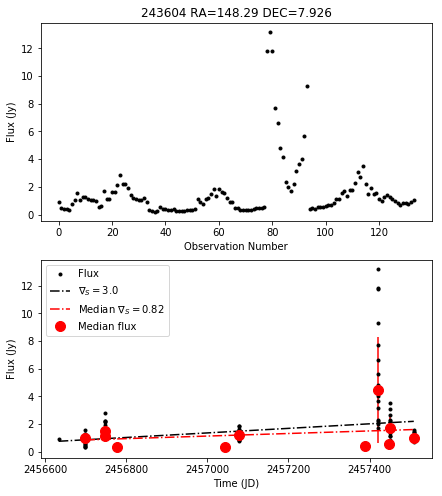

In [65]:
# Make a simple plot of the light-curve
plot_lc(pulsar_id)

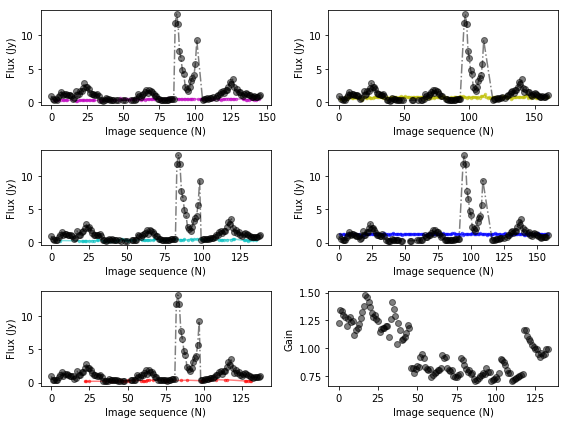

In [66]:
plot_n_lc(pulsar_id) # Show the light-curve of the pulsar with the neighbours. 

In [52]:
# Find the modulation index of the pulsar:
pulsar_stats = stats[stats.source_id==pulsar_id]

In [53]:
pulsar_stats.head()

,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,...,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
63488,63488,243604,148.289559,7.925897,1.600286,2.123395,132.688501,134,17.275734,3.749243e-20,...,0.127136,0.100417,0.143528,-0.039134,0.090564,0.175906,0.177343,0.159967,-0.018932,0.112808


In [57]:
pulsar_stats.Mod.values[0]

132.68850138912563